# Compare dim 1,3,5

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-16 18:55:17.564319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 18:55:17.583063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 18:55:17.588764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [5]:
# We need one place to save all the experiment relevant info.  
gen_experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':5, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(0, 800),
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'eval_time_range' : slice(-128, -64),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    #'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_3_point_stencil'
                    
            }
#gen_experiment_config['num_inputs'] = len(gen_experiment_config['input_channels']) * gen_experiment_config['window_size']**2

In [6]:
particular_experiment_configs = {'1point': gen_experiment_config.copy(), 
                                 '3point': gen_experiment_config.copy(),
                                 '5point': gen_experiment_config.copy() }

In [7]:
particular_experiment_configs['1point']['window_size'] = 1
particular_experiment_configs['3point']['window_size'] = 3
particular_experiment_configs['5point']['window_size'] = 5

particular_experiment_configs['1point']['num_inputs'] = 6
particular_experiment_configs['3point']['num_inputs'] = 54
particular_experiment_configs['5point']['num_inputs'] = 150

particular_experiment_configs['1point']['exp_ckpt_save_dir'] = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/'
particular_experiment_configs['3point']['exp_ckpt_save_dir'] = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/'
particular_experiment_configs['5point']['exp_ckpt_save_dir'] = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_5/'

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [8]:
for exp_point in particular_experiment_configs.keys():
    particular_experiment_configs[exp_point]['networks'] = {'model1' : {'shape': [12,12,2]}, 
                                                             'model2' : {'shape': [24,24,2]},
                                                             'model3' : {'shape': [48,48,2]},
                                                             'model4' : {'shape': [96,96,2]}, 
                                                             'model5' : {'shape': [12,12,12,2]},
                                                             'model6' : {'shape': [48,48,48,2]}, 
                                                             'model7' : {'shape': [192,192,2]} 
                                                               }
    
    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        particular_experiment_configs[exp_point]['networks'][model_key]['save_dir'] = particular_experiment_configs[exp_point]['exp_ckpt_save_dir'] + model_key
            

In [9]:
for exp_point in particular_experiment_configs.keys():
    particular_experiment_configs[exp_point]['DT'] = datasets.SimulationData(
                             simulation_names=particular_experiment_configs[exp_point]['simulation_names'], 
                             filter_scales   =particular_experiment_configs[exp_point]['filter_scales'], 
                             window_size     = particular_experiment_configs[exp_point]['window_size'], 
                             time_sel        = particular_experiment_configs[exp_point]['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [10]:
for exp_point in particular_experiment_configs.keys():
    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        print(particular_experiment_configs[exp_point]['networks'][model_key]['save_dir'])
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'] = evaluation.EvalSystem(
                                     simulation_data = particular_experiment_configs[exp_point]['DT'],
                                     input_channels  = particular_experiment_configs[exp_point]['input_channels'],
                                     output_channels = particular_experiment_configs[exp_point]['output_channels'], 
                                     coeff_channels  = particular_experiment_configs[exp_point]['coeff_channels'], 
                                     extra_channels  = particular_experiment_configs[exp_point]['extra_channels'],
                                     use_norm_factors =True,
                                     eval_time_slice = particular_experiment_configs[exp_point]['eval_time_range'], 
                                     num_inputs      = particular_experiment_configs[exp_point]['num_inputs'], 
                                     shape           = particular_experiment_configs[exp_point]['networks'][model_key]['shape'], 
                                     ckpt_dir        = particular_experiment_configs[exp_point]['networks'][model_key]['save_dir'],
                                     use_coeff_channels = particular_experiment_configs[exp_point]['use_coeff_channels'])
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].read_ann_regression_model()
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].read_eval_data()
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].predict()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model1
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model2
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model3
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model4
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model5
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model6
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_1/model7
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model1
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes

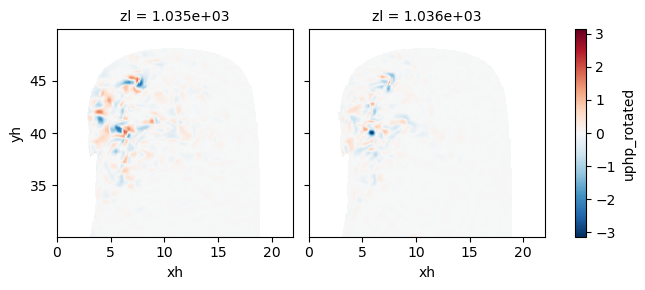

In [37]:
particular_experiment_configs['1point']['networks']['model1']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated.isel(Time=0).plot(col='zl')

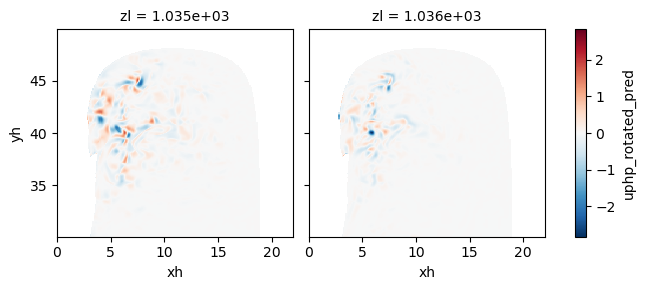

In [36]:
particular_experiment_configs['1point']['networks']['model1']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_pred.isel(Time=0).plot(col='zl')

In [46]:
sel_xh = particular_experiment_configs['1point']['networks']['model1']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].xh

In [47]:
particular_experiment_configs['1point']['networks']['model1']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].sel(xh=sel_xh)

DataTree('50', parent=None)
    Dimensions:                       (Time: 64, xh: 200, yh: 218, zl: 2, Xn: 1,
                                       Yn: 1)
    Coordinates:
      * Time                          (Time) object 512B 0019-06-06 00:00:00 ... ...
      * xh                            (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
      * yh                            (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
      * zl                            (zl) float64 16B 1.035e+03 1.036e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/32)
        dudx_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        dvdx_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        dudy_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        dvdy_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        dhdx_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        dhdy_widened_rotated_nondim   (Time, zl, yh, xh, Xn, Yn) float64 45MB dask.array<chunksize=(12, 2, 218, 200, 1, 1), meta=np.ndarray>
        ...                            ...
        uphp_rotated_R2_time          (zl, yh, xh) float64 698kB dask.array<chunksize=(2, 110, 110), meta=np.ndarray>
        uphp_rotated_corr_time        (zl, yh, xh) float64 698kB dask.array<chunksize=(2, 110, 110), meta=np.ndarray>
        uphp_rotated_mse_time         (zl, yh, xh) float64 698kB dask.array<chunksize=(2, 110, 110), meta=np.ndarray>
        vphp_rotated_R2_time          (zl, yh, xh) float64 698kB nan nan ... nan nan
        vphp_rotated_corr_time        (zl, yh, xh) float64 698kB nan nan ... nan nan
        vphp_rotated_mse_time         (zl, yh, xh) float64 698kB nan nan ... nan nan
    Attributes:
        simulation_name:  DG
        filter_scale:     50
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 50 km resolution

In [52]:
particular_experiment_configs['1point']['networks']['model1']['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'], use_default_subregions=False)

<xarray.DataArray 'uphp_rotated' (Time: 64, zl: 2, yh: 218, xh: 200)> Size: 45MB
dask.array<getitem, shape=(64, 2, 218, 200), dtype=float64, chunksize=(36, 2, 218, 200), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 512B 0019-06-06 00:00:00 ... 0021-02-25 00:00:00
  * xh       (xh) float64 2kB 0.055 0.165 0.275 0.385 ... 21.73 21.84 21.95
  * yh       (yh) float64 2kB 30.14 30.23 30.32 30.41 ... 49.68 49.77 49.86
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
<xarray.DataArray 'uphp_rotated' (Time: 64, zl: 2, yh: 108, xh: 100)> Size: 11MB
dask.array<getitem, shape=(64, 2, 108, 100), dtype=float64, chunksize=(36, 2, 108, 100), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 512B 0019-06-06 00:00:00 ... 0021-02-25 00:00:00
  * xh       (xh) float64 800B 0.11 0.33 0.55 0.77 ... 21.23 21.45 21.67 21.89
  * yh       (yh) float64 864B 30.27 30.45 30.64 30.82 ... 49.36 49.55 49.73
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
<xarray.DataArray 'uphp_

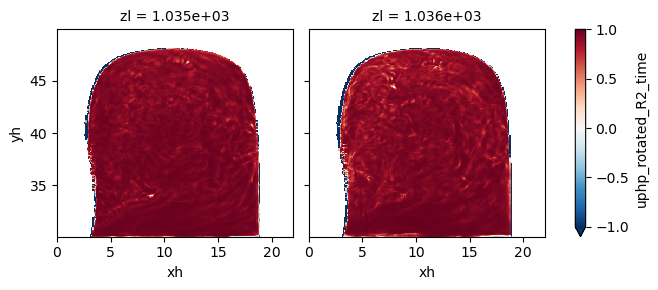

In [57]:
particular_experiment_configs['1point']['networks']['model1']['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)

In [56]:
# Compute some metrics for each model 
for exp_point in particular_experiment_configs.keys():
    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        print(exp_point+', '+ model_key)

        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
        
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)
    
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'], use_default_subregions=False)
        particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'], use_default_subregions=False)

1point, model1
1point, model2
1point, model3
1point, model4
1point, model5
1point, model6
1point, model7
3point, model1
3point, model2
3point, model3
3point, model4
3point, model5
3point, model6
3point, model7
5point, model1
5point, model2
5point, model3
5point, model4
5point, model5
5point, model6
5point, model7


In [13]:
list(particular_experiment_configs.keys())

['1point', '3point', '5point']

Text(0.5, 1.0, 'Model Performance Across Scales')

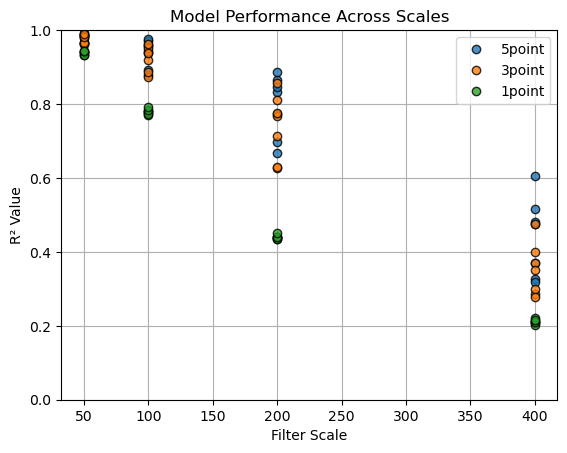

In [58]:
# Define a color map for exp_points
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}

# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for exp_point in exp_points:
    flag = 0
    color = color_map[exp_point]  # Assign a unique color to each exp_point

    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        for scale in particular_experiment_configs[exp_point]['filter_scales']:
            R2_value = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values

            #jitter = np.random.uniform(-5, 5)
            if flag == 0:
                plt.plot(int(scale), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                flag = 1
            else:
                plt.plot(int(scale), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

plt.legend()
plt.xlabel("Filter Scale")
plt.ylabel("R² Value")
plt.ylim([0, 1])
plt.grid()
plt.title("Model Performance Across Scales")
#plt.show()

#plt.savefig('comparing_model_size_and_grid_size_impact.pdf')

Text(0.5, 1.0, 'Model Performance Across Number of parameters (200km)')

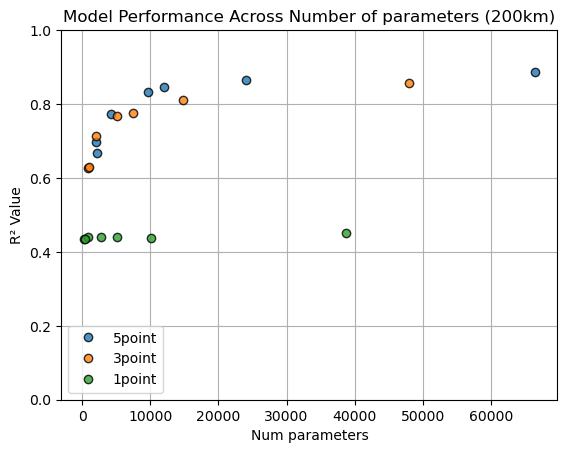

In [59]:
# Define a color map for exp_points
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}

# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for exp_point in exp_points:
    flag = 0
    color = color_map[exp_point]  # Assign a unique color to each exp_point

    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        for scale in ['200']:
            R2_value = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values
            num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
            #jitter = np.random.uniform(-5, 5)
            if flag == 0:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                flag = 1
            else:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

plt.legend()
plt.xlabel("Num parameters")
plt.ylabel("R² Value")
plt.ylim([0, 1])
plt.grid()
plt.title("Model Performance Across Number of parameters (200km)")
#plt.show()

#plt.savefig('comparing_model_size_at_200km.pdf')

In [ ]:
# Define a color map for exp_points
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}

# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for exp_point in exp_points:
    flag = 0
    color = color_map[exp_point]  # Assign a unique color to each exp_point

    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        for scale in ['100']:
            R2_value = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values
            num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
            #jitter = np.random.uniform(-5, 5)
            if flag == 0:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                flag = 1
            else:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

plt.legend()
plt.xlabel("Num parameters")
plt.ylabel("R² Value")
plt.ylim([0, 1])
plt.grid()
plt.title("Model Performance Across Number of parameters (100km)")
#plt.show()

#plt.savefig('comparing_model_size_at_100km.pdf')

In [ ]:
# Define a color map for exp_points
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}

# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for exp_point in exp_points:
    flag = 0
    color = color_map[exp_point]  # Assign a unique color to each exp_point

    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        for scale in ['50']:
            R2_value = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values
            num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
            #jitter = np.random.uniform(-5, 5)
            if flag == 0:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                flag = 1
            else:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

plt.legend()
plt.xlabel("Num parameters")
plt.ylabel("R² Value")
plt.ylim([0, 1])
plt.grid()
plt.title("Model Performance Across Number of parameters (50km)")
#plt.show()

#plt.savefig('comparing_model_size_at_50km.pdf')

In [ ]:
# Define a color map for exp_points
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}

# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for exp_point in exp_points:
    flag = 0
    color = color_map[exp_point]  # Assign a unique color to each exp_point

    for model_key in particular_experiment_configs[exp_point]['networks'].keys():
        for scale in ['400']:
            R2_value = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values
            num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
            #jitter = np.random.uniform(-5, 5)
            if flag == 0:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                flag = 1
            else:
                plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

plt.legend()
plt.xlabel("Num parameters")
plt.ylabel("R² Value")
plt.ylim([0, 1])
plt.grid()
plt.title("Model Performance Across Number of parameters (400km)")
#plt.show()

#plt.savefig('comparing_model_size_at_400km.pdf')

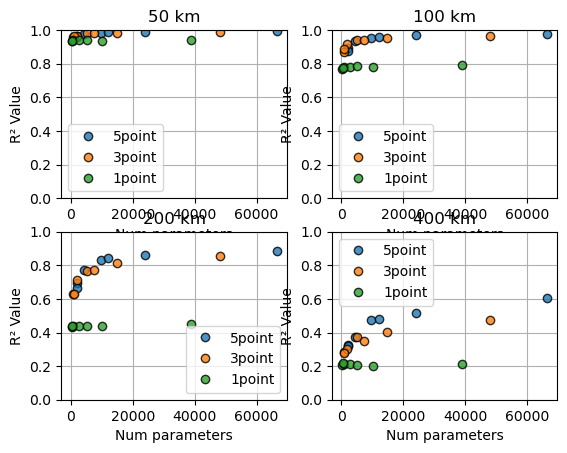

In [60]:
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}


# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

for i, scale in enumerate(['50','100','200','400']):
    plt.subplot(2,2, i + 1)
    for exp_point in exp_points:
        flag = 0
        color = color_map[exp_point]  # Assign a unique color to each exp_point

        for model_key in particular_experiment_configs[exp_point]['networks'].keys():
            
                R2_value = 0.5*(particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                                particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values )
                num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
                #jitter = np.random.uniform(-5, 5)
                if flag == 0:
                    plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')
                    flag = 1
                else:
                    plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')

    plt.legend()
    plt.xlabel("Num parameters")
    plt.ylabel("R² Value")
    plt.ylim([0, 1])
    plt.grid()
    plt.title(scale+' km')
plt.tight

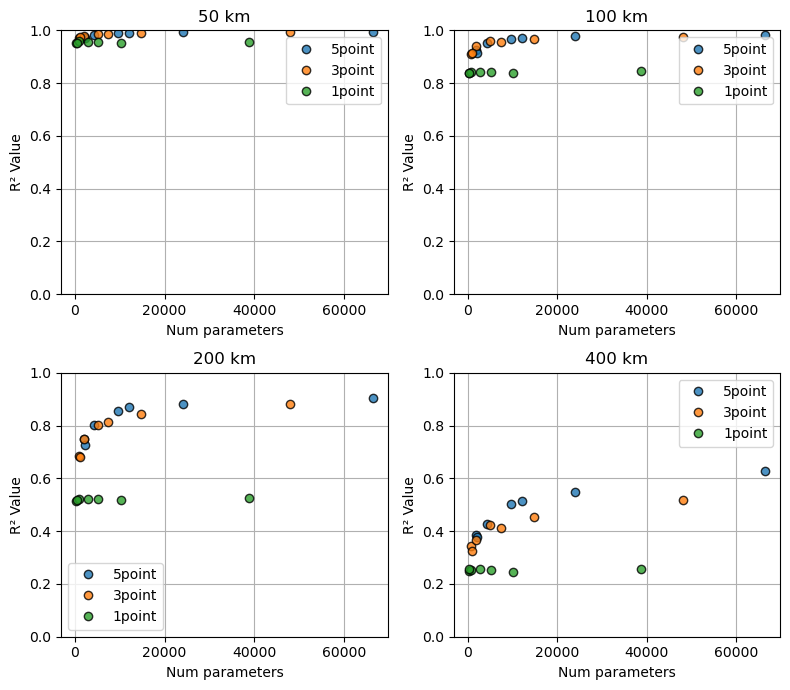

In [62]:
exp_name = 'DG'
colors = plt.cm.tab10.colors  # You can choose another colormap
exp_points = list(particular_experiment_configs.keys())
exp_points.reverse()
color_map = {exp: colors[i] for i, exp in enumerate(exp_points)}


# Define markers
marker_map = {'1point': 'o', '3point': 'o', '5point': 'o'}

plt.figure(figsize=(8,7))

for i, scale in enumerate(['50','100','200','400']):
    plt.subplot(2,2, i + 1)
    for exp_point in exp_points:
        flag = 0
        color = color_map[exp_point]  # Assign a unique color to each exp_point

        for model_key in particular_experiment_configs[exp_point]['networks'].keys():
            
                R2_value = 0.5*(particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                                particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values )
                num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()
                #jitter = np.random.uniform(-5, 5)
                if flag == 0:
                    plt.plot(int(num_params), R2_value, marker_map[exp_point], label=str(exp_point), color=color, alpha=0.8,markeredgecolor='black')

                else:
                    plt.plot(int(num_params), R2_value, marker_map[exp_point], color=color, alpha=0.8, markeredgecolor='black')
                    
             
    plt.xlabel("Num parameters")
    plt.ylabel("R² Value")
    plt.ylim([0, 1])
    plt.grid()
    plt.title(scale+' km')
    
plt.tight()

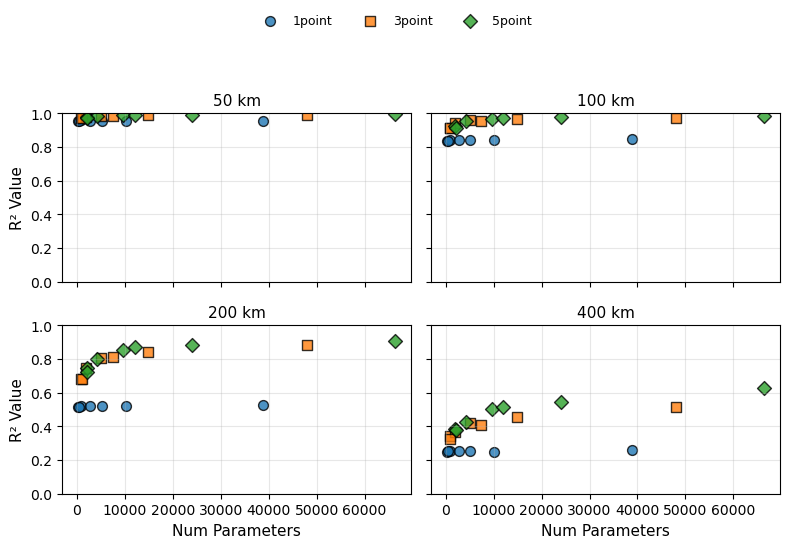

In [65]:
import matplotlib.pyplot as plt
import numpy as np

exp_name = 'DG'
colors = plt.cm.tab10.colors  # Colormap

exp_points = list(particular_experiment_configs.keys())
color_map = {exp: colors[i % len(colors)] for i, exp in enumerate(exp_points)}  # Cycle colors if needed

# Define distinct markers for different categories
marker_map = {'1point': 'o', '3point': 's', '5point': 'D'}  # Circle, square, diamond

scales = ['50', '100', '200', '400']
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)  # Smaller size

for i, scale in enumerate(scales):
    ax = axes[i // 2, i % 2]  # Arrange in 2x2 grid
    
    for exp_point in exp_points:
        color = color_map[exp_point]  # Assign color
        marker = marker_map.get(exp_point, 'o')  # Default marker if missing
        
        num_params_list = []
        R2_values_list = []

        for model_key in particular_experiment_configs[exp_point]['networks']:
            try:
                R2_value = 0.5 * (
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
                )
                num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()

                num_params_list.append(int(num_params))
                R2_values_list.append(R2_value)
            except KeyError:
                continue  # Skip missing entries

        if len(num_params_list) > 0:
            ax.scatter(num_params_list, R2_values_list, 
                       label=str(exp_point), color=color, marker=marker, 
                       alpha=0.8, edgecolors='black', s=50)  # Slightly smaller points

    ax.set_title(f"{scale} km", fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    
    if i // 2 == 1:  # Bottom row
        ax.set_xlabel("Num Parameters", fontsize=11)
    if i % 2 == 0:  # Left column
        ax.set_ylabel("R² Value", fontsize=11)

# Move legend above all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(exp_points), fontsize=9, frameon=False, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for space
plt.show()


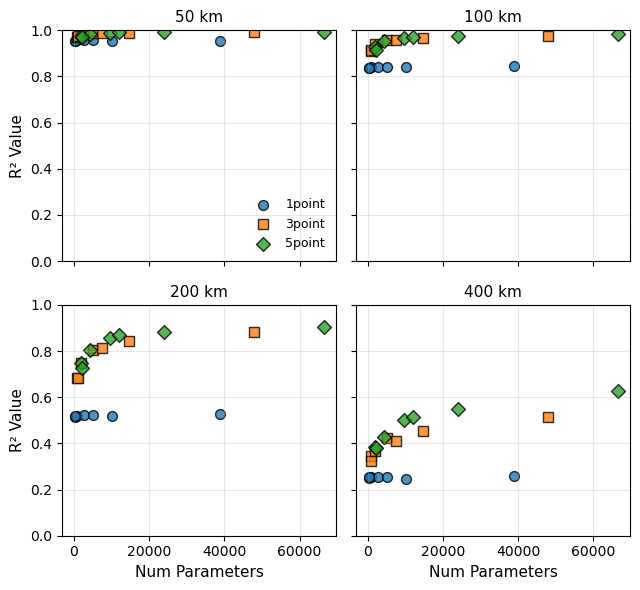

In [67]:
import matplotlib.pyplot as plt
import numpy as np

exp_name = 'DG'
colors = plt.cm.tab10.colors  # Colormap

exp_points = list(particular_experiment_configs.keys())
color_map = {exp: colors[i % len(colors)] for i, exp in enumerate(exp_points)}  # Cycle colors if needed

# Define distinct markers for different categories
marker_map = {'1point': 'o', '3point': 's', '5point': 'D'}  # Circle, square, diamond

scales = ['50', '100', '200', '400']
fig, axes = plt.subplots(2, 2, figsize=(6.5, 6), sharex=True, sharey=True)  # More square layout

for i, scale in enumerate(scales):
    ax = axes[i // 2, i % 2]  # Arrange in 2x2 grid
    
    for exp_point in exp_points:
        color = color_map[exp_point]  # Assign color
        marker = marker_map.get(exp_point, 'o')  # Default marker if missing
        
        num_params_list = []
        R2_values_list = []

        for model_key in particular_experiment_configs[exp_point]['networks']:
            try:
                R2_value = 0.5 * (
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
                )
                num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()

                num_params_list.append(int(num_params))
                R2_values_list.append(R2_value)
            except KeyError:
                continue  # Skip missing entries

        if len(num_params_list) > 0:
            ax.scatter(num_params_list, R2_values_list, 
                       label=str(exp_point), color=color, marker=marker, 
                       alpha=0.8, edgecolors='black', s=50)  # Adjusted marker size

    ax.set_title(f"{scale} km", fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)

    if i == 0:  # Only add legend to the first panel (top-left)
        ax.legend(fontsize=9, loc="lower right", frameon=False)

    if i // 2 == 1:  # Bottom row
        ax.set_xlabel("Num Parameters", fontsize=11)
    if i % 2 == 0:  # Left column
        ax.set_ylabel("R² Value", fontsize=11)

plt.tight_layout()  # Optimize spacing

plt.savefig('comparing_model_sizes_across_scale.pdf')
#plt.show()


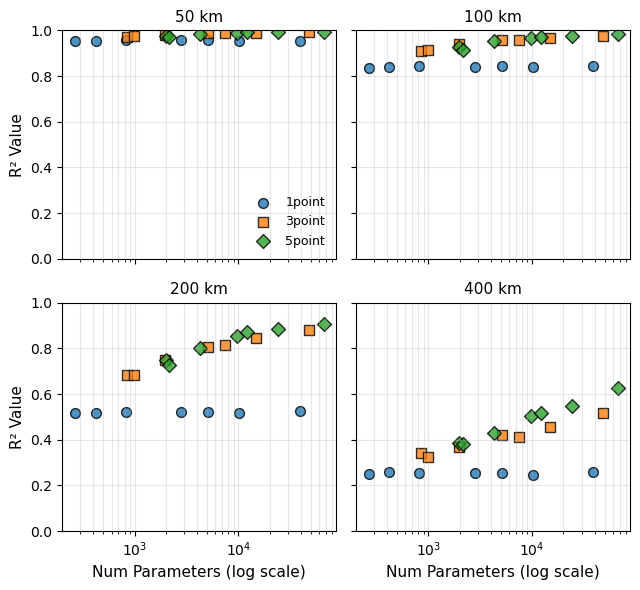

In [69]:
import matplotlib.pyplot as plt
import numpy as np

exp_name = 'DG'
colors = plt.cm.tab10.colors  # Colormap

exp_points = list(particular_experiment_configs.keys())
color_map = {exp: colors[i % len(colors)] for i, exp in enumerate(exp_points)}  # Cycle colors if needed

# Define distinct markers for different categories
marker_map = {'1point': 'o', '3point': 's', '5point': 'D'}  # Circle, square, diamond

scales = ['50', '100', '200', '400']
fig, axes = plt.subplots(2, 2, figsize=(6.5, 6), sharex=True, sharey=True)  # More square layout

for i, scale in enumerate(scales):
    ax = axes[i // 2, i % 2]  # Arrange in 2x2 grid
    
    for exp_point in exp_points:
        color = color_map[exp_point]  # Assign color
        marker = marker_map.get(exp_point, 'o')  # Default marker if missing
        
        num_params_list = []
        R2_values_list = []

        for model_key in particular_experiment_configs[exp_point]['networks']:
            try:
                R2_value = 0.5 * (
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                    particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
                )
                num_params = particular_experiment_configs[exp_point]['networks'][model_key]['eval_sys'].regress_sys.network.count_parameters()

                num_params_list.append(int(num_params))
                R2_values_list.append(R2_value)
            except KeyError:
                continue  # Skip missing entries

        if len(num_params_list) > 0:
            ax.scatter(num_params_list, R2_values_list, 
                       label=str(exp_point), color=color, marker=marker, 
                       alpha=0.8, edgecolors='black', s=50)  # Adjusted marker size

    ax.set_xscale("log")  # Set x-axis to logarithmic scale
    ax.set_title(f"{scale} km", fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3, which="both")  # Grid on both major and minor ticks

    if i == 0:  # Only add legend to the first panel (top-left)
        ax.legend(fontsize=9, loc="lower right", frameon=False)

    if i // 2 == 1:  # Bottom row
        ax.set_xlabel("Num Parameters (log scale)", fontsize=11)
    if i % 2 == 0:  # Left column
        ax.set_ylabel("R² Value", fontsize=11)

plt.tight_layout()  # Optimize spacing

plt.savefig('comparing_model_sizes_across_scale_logx.pdf')
